## PDFから指定されたセクションを抽出する

In [233]:
import fitz  # PyMuPDF
import re
from pathlib import Path
import pandas as pd
import requests
from io import BytesIO



In [234]:

# 1. PDF -> テキスト結合
def extract_text_all(pdf_path: str) -> str:
    doc = fitz.open(pdf_path)
    texts = []
    for page in doc:
        texts.append(page.get_text("text"))
    return "\n".join(texts)


In [ ]:
HEADING_PATTERNS = [
    r'^\s*[0-9０-９IVX一二三四五六七八九十]+(?:[\.\-．、.][0-9０-９一二三四五六七八九十]+)*[\s　]*(教訓|提言)',
    r'^\s*[0-9０-９IVX一二三四五六七八九十]*[\s　]*(教訓|提言)',
    r'^\s*[0-9０-９IVX一二三四五六七八九十]+(?:[\.\-．、.][0-9０-９一二三四五六七八九十]+)*[\s　]*(教訓・提言)',
    r'^\s*[0-9０-９IVX一二三四五六七八九十]*[\s　]*(教訓・提言)',
    r'^\s*[0-9０-９IVX一二三四五六七八九十]+(?:[\.\-．、.][0-9０-９一二三四五六七八九十]+)*[\s　]*(教訓•提言)',
    r'^\s*[0-9０-９IVX一二三四五六七八九十]*[\s　]*(教訓•提言)',
    r'(教訓・提言)',

    r'^\s*[0-9０-９IVX一二三四五六七八九十]+(?:[\.\-．、.][0-9０-９一二三四五六七八九十]+)*[\s　]*(提言・教訓)',
    r'^\s*[0-9０-９IVX一二三四五六七八九十]*[\s　]*(提言・教訓)',
    r'^\s*[0-9０-９IVX一二三四五六七八九十]+(?:[\.\-．、.][0-9０-９一二三四五六七八九十]+)*[\s　]*(提言•教訓)',
    r'^\s*[0-9０-９IVX一二三四五六七八九十]*[\s　]*(提言•教訓)',
    r'(提言・教訓)',
    
]

In [236]:
import re

def is_noise_paragraph(text: str) -> bool:
    s = text.strip()

    # 1. まず改行を消した短さチェック用文字列
    s_compact = s.replace("\n", "").strip()

    # 1. 極端に短い
    if len(s_compact) < 8:
        return True

    # 2. 各行が「提言」「教訓」「結論」などだけの行ばかり → ノイズ
    lines = [l.strip() for l in s.splitlines() if l.strip()]
    if lines:
        if all(re.fullmatch(r'[・･\-\.\s　]*(提言|教訓|結論)[・･\-\.\s　]*', l) for l in lines):
            return True

    # 3. 全体で「提言」「教訓」「結論」の繰り返しだけ
    compressed = re.sub(r'[・･\-\.\s　\n]+', '', s)
    if re.fullmatch(r'(提言|教訓|結論)+', compressed):
        return True

    # 4. 脚注っぽい（数字+短いテキスト）
    if re.match(r'^[0-9０-９]+\s', s_compact) and len(s_compact) < 25:
        return True

    # 5. 「主要計画／実績比較」など表見出しブロック
    #   - 主要計画 を含み、
    #   - 「実績比較」か「項  目」「計  画」「実  績」など典型的なカラム名が並んでいる
    if "主要計画" in s:
        if ("実績比較" in s
            or "項  目" in s
            or "計  画" in s
            or "実  績" in s):
            return True

    # 6. 明らかに表形式ぽい：句点がなく、改行だらけ、名詞だけ
    if "。" not in s and len(lines) >= 3:
        # かなり強めに表・見出し臭いものは弾く
        header_keywords = ["項  目", "計  画", "実  績", "指標", "区分"]
        if any(k in s for k in header_keywords):
            return True

    return False

In [237]:
import re

def is_heading_line(s: str) -> bool:
    """数字やローマ数字＋区切り記号＋短いテキスト（句点なし）を見出し候補とみなす。"""
    s = s.strip()
    if "。" in s:
        return False
    return bool(re.match(
        r'^[\s　]*[0-9０-９IVX一二三四五六七八九十]+(?:[\.．\-、][0-9０-９一二三四五六七八九十]+)*[\s　]+.{1,40}$',
        s
    ))


def find_kadai_section(full_text: str) -> str | None:
    lines = full_text.splitlines()

    # 教訓・提言セクション開始を探す
    start_idx = None
    for i, line in enumerate(lines):
        normalized = line.strip()
        for pat in HEADING_PATTERNS:
            if re.search(pat, normalized):
                start_idx = i
                break
        if start_idx is not None:
            break
    if start_idx is None:
        return None

    # 終了条件：
    #  (1) 「以上」「以 上」「以　上」「(以上)」「（以 上）」など
    #  (2) 「コラム」や「主要計画」を含む行
    #  (3) 別の見出し行
    end_idx = len(lines)
    END_LINE_PAT = r'^[\s　]*[（(]?\s*以[\s　]*上\s*[)）]?[\s　]*$'

    for j in range(start_idx + 1, len(lines)):
        line = lines[j].strip()

        # (1) 以上系
        if re.search(END_LINE_PAT, line):
            end_idx = j
            break

        # --- 修正版: 主要計画（全角・空白・スラッシュなど含む） ---
        if re.search(r'主[\s　]*要[\s　]*計[\s　]*画', line):
            end_idx = j
            break

        # --- 修正版: 主要計画（全角・空白・スラッシュなど含む） ---
        if re.search(r'コ[\s　]*ラ[\s　]*ム', line):
            end_idx = j
            break

    section_lines = lines[start_idx:end_idx]
    return "\n".join(section_lines)

In [238]:
import re

def is_page_number_line(s: str) -> bool:
    s = s.strip()
    # 完全に数字だけ / 前後に-や()だけの数字 → ページ番号とみなす
    if re.fullmatch(r'[0-9０-９]+', s):
        return True
    if re.fullmatch(r'[-–－\-（(]?\s*[0-9０-９]+\s*[-–－\-）)]?', s):
        return True
    return False


def split_into_paragraphs(section_text: str) -> list[str]:
    """
    セクションテキストを段落ごとに分割する。
    - ページ番号行を事前に削除
    - その後、ページまたぎで切れた短い行を前の段落にマージ
    """

    # 1) ページ番号行を削除
    cleaned_lines = []
    for line in section_text.splitlines():
        if is_page_number_line(line):
            continue
        cleaned_lines.append(line)

    cleaned_text = "\n".join(cleaned_lines)

    # 2) 空行ベースでざっくり段落分割
    raw_blocks = re.split(r'\n\s*\n', cleaned_text)
    paras = []
    for blk in raw_blocks:
        p = blk.strip()
        if not p:
            continue
        # 見出しカスみたいな極端に短いものは除外（必要なら調整）
        if len(p) < 10:
            continue
        paras.append(p)

    # 3) 「ページまたぎで分裂した短い行」を前の段落にマージ
    merged: list[str] = []
    for p in paras:
        if not merged:
            merged.append(p)
            continue

        prev = merged[-1]

        # マージ条件：
        # - 前の段落が「。」「！」「？」で終わっていない
        # - 今の段落が比較的短い（例: 40文字以下）
        # - 今の段落が見出しっぽくない（行頭が数字や「第」「●」などで始まらない）
        if (not re.search(r'[。！？]$', prev)
                and len(p) <= 40
                and not re.match(r'^[0-9０-９第・●･\-\(（]', p.strip())):
            # 前の段落にくっつける（改行を入れるかどうかは好み）
            merged[-1] = prev.rstrip() + p.lstrip()
        else:
            merged.append(p)

    return merged

In [239]:
def load_pdf_text(source: str) -> str:
    """
    source が
      - http(s) で始まる場合: Web上のPDFとして取得
      - それ以外: ローカルパスとして扱う
    全ページのテキストを結合して返す。
    """
    if source.startswith("http://") or source.startswith("https://"):
        # URLからPDFを取得
        resp = requests.get(source, timeout=30)
        resp.raise_for_status()
        pdf_bytes = resp.content
        doc = fitz.open(stream=BytesIO(pdf_bytes), filetype="pdf")
    else:
        # ローカルファイルとして開く
        doc = fitz.open(source)

    texts = []
    for page in doc:
        texts.append(page.get_text("text"))
    doc.close()
    return "\n".join(texts)

In [240]:
def extract_kadai_paragraphs(source: str,
                             project_id: str | None = None) -> pd.DataFrame:
    """
    1つの評価報告書（URL or ローカルパス）から、
    「教訓・提言」系セクションの段落を抜き出して DataFrame を返す。

    columns:
        project_id, para_id, text, source
    """
    full_text = load_pdf_text(source)
    kadai_section = find_kadai_section(full_text)

    if kadai_section is None:
        print(f"[WARN] 教訓・提言セクションが見つからない: {source}")
        return pd.DataFrame(columns=["project_id", "para_id", "text", "source"])

    paras = split_into_paragraphs(kadai_section)

    # 一旦 DataFrame に
    if project_id is None:
        if source.startswith("http"):
            project_id = Path(source).name  # ファイル名部分だけ
        else:
            project_id = Path(source).name

    df = pd.DataFrame(
        {
            "project_id": project_id,
            "para_id": list(range(len(paras))),
            "text": paras,
            "source": source,
        }
    )

    # ノイズ段落削除
    df = df[~df["text"].apply(is_noise_paragraph)].reset_index(drop=True)

    # para_id を振り直し
    df["para_id"] = range(len(df))

    return df


In [241]:
except_file_list = [
    # フォーマットが特殊
    'https://www2.jica.go.jp/ja/evaluation/pdf/2010_VNXI-3_4_f.pdf'
]

In [242]:
df = pd.read_csv("../df_check_99.csv")
target_urls = df["file"].dropna().unique().tolist()
#target_urls = target_urls[0:200]  # テスト用

#target_urls = ["https://www2.jica.go.jp/ja/evaluation/pdf/2010_C01-P160_4_f.pdf"]
df_out = pd.DataFrame()
for i,url in enumerate(target_urls):
    if url in except_file_list:
        print(f"=== {i} {url} SKIPPED ===")
        continue
    df_kadai = extract_kadai_paragraphs(url)
    print(f"=== {i} {url} ===")
    df_out = pd.concat([df_out, df_kadai], ignore_index=True)


=== 0 https://www2.jica.go.jp/ja/evaluation/pdf/2010_0200600_4_f.pdf ===
=== 1 https://www2.jica.go.jp/ja/evaluation/pdf/2010_0202100_4_f.pdf ===
=== 2 https://www2.jica.go.jp/ja/evaluation/pdf/2010_0202700_4_f.pdf ===
=== 3 https://www2.jica.go.jp/ja/evaluation/pdf/2010_0211100_4_f.pdf ===
=== 4 https://www2.jica.go.jp/ja/evaluation/pdf/2010_0300500_4_f.pdf ===
=== 5 https://www2.jica.go.jp/ja/evaluation/pdf/2010_0300700_4_f.pdf ===
=== 6 https://www2.jica.go.jp/ja/evaluation/pdf/2010_0304000_4_f.pdf ===
=== 7 https://www2.jica.go.jp/ja/evaluation/pdf/2010_0306300_4_f.pdf ===
=== 8 https://www2.jica.go.jp/ja/evaluation/pdf/2010_0307400_4_f.pdf ===
=== 9 https://www2.jica.go.jp/ja/evaluation/pdf/2010_0308100_4_f.pdf ===
=== 10 https://www2.jica.go.jp/ja/evaluation/pdf/2010_0309700_4_f.pdf ===
=== 11 https://www2.jica.go.jp/ja/evaluation/pdf/2010_0400200_4_f.pdf ===
=== 12 https://www2.jica.go.jp/ja/evaluation/pdf/2010_0400300_4_f.pdf ===
=== 13 https://www2.jica.go.jp/ja/evaluation/pdf

In [243]:
# クレンジング
import re

def is_noise_paragraph(text: str) -> bool:
    s = str(text).strip()
    s_compact = s.replace("\n", "").strip()

    # 1. 極端に短い
    if len(s_compact) < 8:
        return True

    # 2. 教訓・提言・結論だけが並んでる系
    lines = [l.strip() for l in s.splitlines() if l.strip()]
    if lines:
        if all(re.fullmatch(r'[・･\-\.\s　]*(提言|教訓|結論)[・･\-\.\s　]*', l) for l in lines):
            return True

    # 3. 全体でも「提言/教訓/結論」だけ
    compressed = re.sub(r'[・･\-\.\s　\n]+', '', s)
    if re.fullmatch(r'(提言|教訓|結論)+', compressed):
        return True

    # 4. 脚注系（数字＋短文）
    if re.match(r'^[0-9０-９]+\s', s_compact) and len(s_compact) < 25:
        return True

    # 5. 主要計画／実績比較＋典型的カラム名
    if "主要計画" in s:
        if ("実績比較" in s
            or "項  目" in s
            or "計  画" in s
            or "実  績" in s):
            return True

    # 6. 表ヘッダーっぽい（句点なし＋複数行＋カラム語）
    if "。" not in s and len(lines) >= 3:
        header_keywords = ["項  目", "計  画", "実  績", "指標", "区分"]
        if any(k in s for k in header_keywords):
            return True

    return False

# 実際に適用
df_out = df_out[~df_out["text"].apply(is_noise_paragraph)].reset_index(drop=True)

In [244]:
# レーティングを結合
df_out = df_out.merge(
    df[["file", "total_eval"]],
    left_on="source",
    right_on="file",
    how="left"
).drop(columns=["file"])

In [247]:
# project_idごとの段落数をカラムに追加
df_out["project_para_count"] = df_out.groupby("project_id")["para_id"].transform("count")

# 確認（任意）
df_out[["project_id", "para_id", "project_para_count"]].head()

,project_id,para_id,project_para_count
0,2010_0200600_4_f.pdf,0,3
1,2010_0200600_4_f.pdf,1,3
2,2010_0200600_4_f.pdf,2,3
3,2010_0202100_4_f.pdf,0,7
4,2010_0202100_4_f.pdf,1,7


In [248]:
df_out = df_out[df_out["project_para_count"]<=5]

In [249]:
df_out

,project_id,para_id,text,source,total_eval,project_para_count
0,2010_0200600_4_f.pdf,0,4.2 提言 \n4.2.1 実施機関への提言 \n事後評価時において、アティ橋、イクサ橋と...,https://www2.jica.go.jp/ja/evaluation/pdf/2010...,4.0,3
1,2010_0200600_4_f.pdf,1,4.2.2 JICAへの提言 \nなし。,https://www2.jica.go.jp/ja/evaluation/pdf/2010...,4.0,3
2,2010_0200600_4_f.pdf,2,4.3 教訓 \n事前評価時に設定された運用効果指標の大半は実施機関でデータ収集がなされてい...,https://www2.jica.go.jp/ja/evaluation/pdf/2010...,4.0,3
10,2010_0202700_4_f.pdf,0,4.2 提言 \n 4.2.1 実施機関への提言 \n基礎データの精度向上 \n基本設計調査...,https://www2.jica.go.jp/ja/evaluation/pdf/2010...,3.0,4
11,2010_0202700_4_f.pdf,1,雨漏りへの対応 \nオルホン県の2 校の雨漏りは、これまで学校側で補修を試みてきているが、雨...,https://www2.jica.go.jp/ja/evaluation/pdf/2010...,3.0,4
...,...,...,...,...,...,...
10414,2024_1400502_4_f.pdf,3,ゴウサの廃棄物処理場でのトラックの積み下ろし作業 \nAEPB の車両メンテナンス作業場,https://www2.jica.go.jp/ja/evaluation/pdf/2024...,2.0,4
10415,2024_1600418_4_f.pdf,0,IV 提言・教訓 \n実施機関（KAFD）への提言： \n・現在、大学で提供されているキャリ...,https://www2.jica.go.jp/ja/evaluation/pdf/2024...,4.0,3
10416,2024_1600418_4_f.pdf,1,JICA への教訓： \n・COVID-19 の感染拡大は、本事業完了直後の2020 年3 ...,https://www2.jica.go.jp/ja/evaluation/pdf/2024...,4.0,3
10417,2024_1600418_4_f.pdf,2,2018 年のアンマンで実施された「キャリアカ\nウンセラー研修」でのMOL 及びKAFD ...,https://www2.jica.go.jp/ja/evaluation/pdf/2024...,4.0,3


In [250]:
df_out.to_csv('../kadai_text_with_rating.csv', index=False)

In [251]:
import pandas as pd
df_out = pd.read_csv('../kadai_text_with_rating.csv')

## BERTで埋め込みベクトル作成

In [252]:
%pip install "protobuf<3.21" --upgrade
%pip install -U "transformers" "sentence-transformers"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [253]:
from sentence_transformers import SentenceTransformer
import numpy as np

model_name = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
model = SentenceTransformer(model_name)

texts = df_out["text"].tolist()
embeddings = model.encode(
    texts,
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True
)  # shape: (N, D)

print(embeddings.shape)

Batches:   0%|          | 0/51 [00:00<?, ?it/s]

(3217, 384)


## クラスタリング

In [258]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# すでに embeddings がある前提: shape = (N_paragraphs, D)

# 1. PCAで次元削減（例: 50次元）
pca_dim = 50
pca = PCA(n_components=pca_dim, random_state=42)
X_reduced = pca.fit_transform(embeddings)

# 2. k-meansでクラスタリング
K = 20  # 後で変えて比較してもいい
km = KMeans(n_clusters=K, random_state=42, n_init="auto")
cluster_labels = km.fit_predict(X_reduced)

df_out["cluster"] = cluster_labels

# 3. 悪い評価フラグ（ここでは total_eval が 1 or 2 を「悪い」と仮定）
def is_bad(r):
    if pd.isna(r):
        return np.nan
    return 1 if r in [1.0, 2.0] else 0

df_out["bad_flag"] = df_out["total_eval"].apply(is_bad)

# 4. ドキュメント（project_id）ごとの段落数をカウント
doc_counts = df_out.groupby("project_id")["text"].size().to_dict()

# 5. 各段落に「1ドキュメントを1票にするための重み」を付与
#    → 段落が多いドキュメントほど1段落あたりの重みを小さくする
df_out["doc_weight"] = df_out["project_id"].map(lambda pid: 1.0 / doc_counts.get(pid, 1))

# 6. クラスタ別集計
def agg_cluster(g: pd.DataFrame) -> pd.Series:
    n = len(g)
    # 単純平均 (段落ベース)
    bad_ratio = g["bad_flag"].mean()

    # 重み付き平均 (文書ベース: doc_weight で重み付け)
    mask = g["bad_flag"].notna()
    if mask.any():
        bad_ratio_w = np.average(
            g.loc[mask, "bad_flag"],
            weights=g.loc[mask, "doc_weight"]
        )
    else:
        bad_ratio_w = np.nan

    return pd.Series({
        "n": n,
        "bad_ratio": bad_ratio,
        "bad_ratio_weighted": bad_ratio_w,
    })

cluster_stats = (
    df_out
    .groupby("cluster")
    .apply(agg_cluster)
    .reset_index()
    .sort_values("bad_ratio_weighted", ascending=False)
)

print(cluster_stats)



    cluster      n  bad_ratio  bad_ratio_weighted
18       18  170.0   0.315476            0.341722
7         7   76.0   0.328947            0.322932
1         1  121.0   0.261261            0.277701
16       16  120.0   0.216667            0.263265
12       12  148.0   0.178082            0.256640
17       17  214.0   0.252336            0.255092
19       19  156.0   0.217105            0.246274
10       10  233.0   0.185022            0.244815
5         5  173.0   0.189349            0.236891
2         2  193.0   0.219251            0.230812
0         0  115.0   0.219298            0.227068
3         3   91.0   0.197802            0.218023
11       11  130.0   0.230769            0.202807
13       13  207.0   0.170000            0.185591
15       15  112.0   0.145455            0.163563
8         8  145.0   0.144828            0.157933
14       14  112.0   0.158879            0.131241
9         9  215.0   0.144186            0.130202
6         6  311.0   0.094771            0.094527


/tmp/ipykernel_75453/1348823781.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(agg_cluster)


/tmp/ipykernel_75453/1144484603.py:16: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_75453/1144484603.py:16: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_75453/1144484603.py:16: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_75453/1144484603.py:16: UserWarning: Glyph 12479 (\N{KATAKANA LETTER TA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_75453/1144484603.py:16: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_75453/1144484603.py:16: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_75453/1144484603.py:16: UserWarning: Glyph 12415 (\N{HIRAGANA LETTER MI}) missing from font(s) DejaVu San

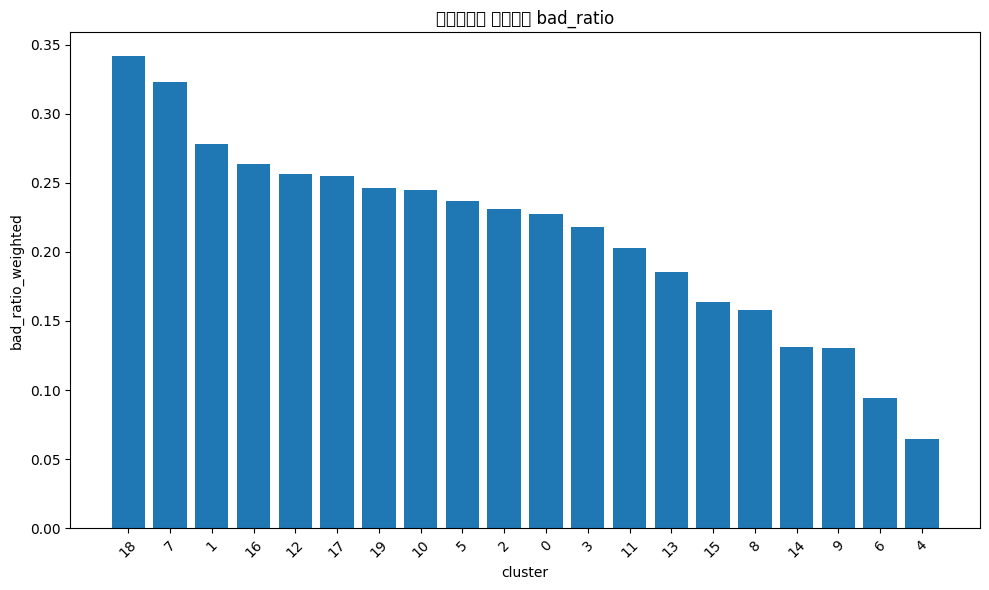

In [ ]:
# =========================
# ここから図示パート
# =========================

# (A) クラスタ別 bad_ratio_weighted の棒グラフ
plt.figure(figsize=(10, 6))
# 並び替え済み cluster_stats をそのまま使う
x = cluster_stats["cluster"].astype(str)
y = cluster_stats["bad_ratio_weighted"]

plt.bar(x, y)
plt.xlabel("cluster")
plt.ylabel("bad_ratio_weighted")
plt.title("weighted bad_ratio")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


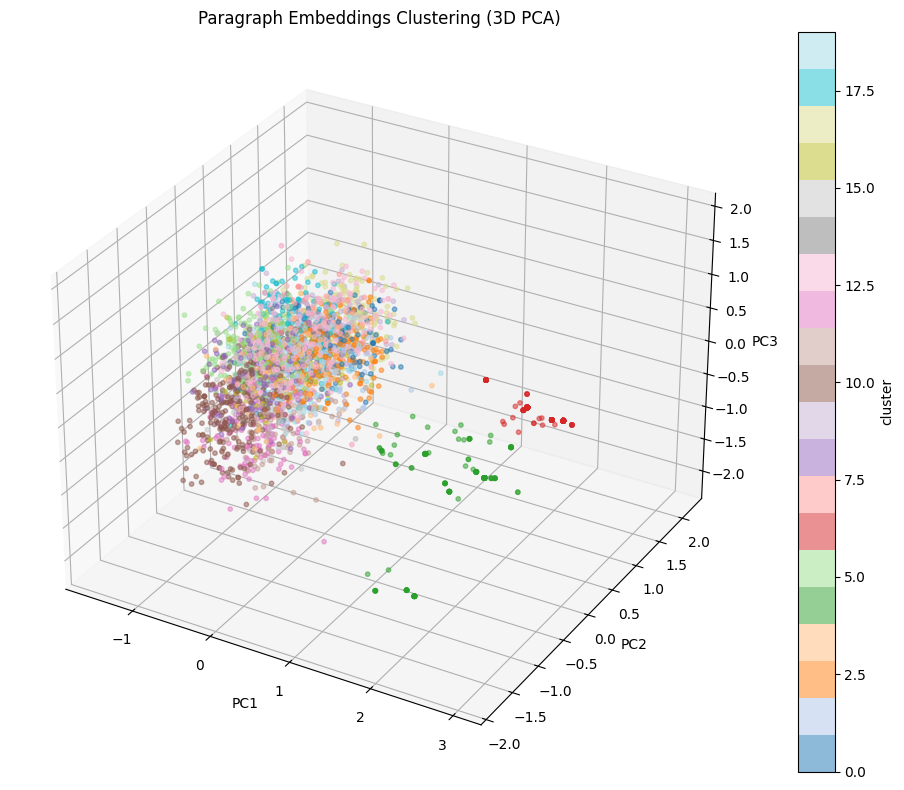

In [268]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # 3Dプロット用
import matplotlib.pyplot as plt

# --- 可視化用に3次元PCA ---
pca_3d = PCA(n_components=3, random_state=42)
X_3d = pca_3d.fit_transform(embeddings)

df_out["pc1"] = X_3d[:, 0]
df_out["pc2"] = X_3d[:, 1]
df_out["pc3"] = X_3d[:, 2]

# --- 3Dプロット ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(
    df_out["pc1"],
    df_out["pc2"],
    df_out["pc3"],
    c=df_out["cluster"],
    cmap="tab20",
    alpha=0.5,
    s=10
)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Paragraph Embeddings Clustering (3D PCA)")
fig.colorbar(p, ax=ax, label="cluster")

plt.tight_layout()
plt.show()

/tmp/ipykernel_75453/868714113.py:15: UserWarning: Glyph 27573 (\N{CJK UNIFIED IDEOGRAPH-6BB5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_75453/868714113.py:15: UserWarning: Glyph 33853 (\N{CJK UNIFIED IDEOGRAPH-843D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_75453/868714113.py:15: UserWarning: Glyph 22475 (\N{CJK UNIFIED IDEOGRAPH-57CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_75453/868714113.py:15: UserWarning: Glyph 12417 (\N{HIRAGANA LETTER ME}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_75453/868714113.py:15: UserWarning: Glyph 36796 (\N{CJK UNIFIED IDEOGRAPH-8FBC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_75453/868714113.py:15: UserWarning: Glyph 12415 (\N{HIRAGANA LETTER MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_75453/868714113.py:15: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from f

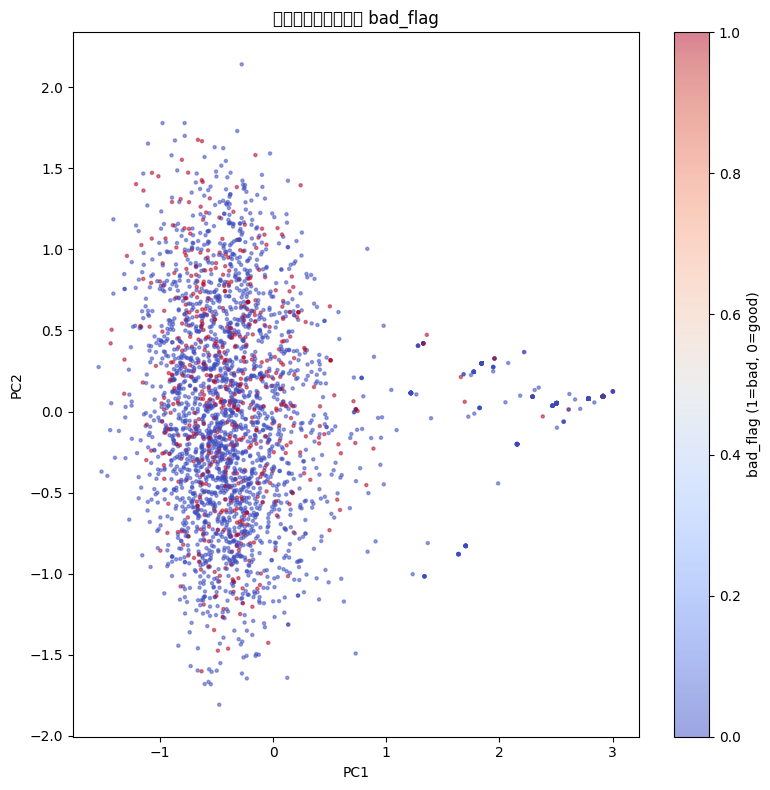

In [262]:

# （オプション）bad_flag を色にして、「悪い評価寄りの段落がどこに固まっているか」を見るなら:
plt.figure(figsize=(8, 8))
scatter2 = plt.scatter(
    df_out["pc1"],
    df_out["pc2"],
    c=df_out["bad_flag"],
    cmap="coolwarm",
    alpha=0.5,
    s=5
)
plt.colorbar(scatter2, label="bad_flag (1=bad, 0=good)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("段落埋め込み分布と bad_flag")
plt.tight_layout()
plt.show()

In [255]:
top_clusters = cluster_stats.sort_values("bad_ratio", ascending=False)["cluster"].tolist()

for c in top_clusters:
    print(f"\n=== Cluster {c} ===")
    subset = df_out[df_out["cluster"] == c].sample(5, random_state=42)
    for t in subset["text"]:
        print("-", t.replace("\n", " "))


=== Cluster 7 ===
- ■バリ流域管理事務所の維持管理体制・予算確保状況に関して、適時JICA 駐在員事務所は 維持管理体制の整備や実施状況を確認し、必要に応じて助言等を行うことが望ましい。現 状として重大な懸念はないが、将来に亘る持続性を確保する観点において有益であると考 えられる。 4.3 教訓 （バリ流域管理事務所への教訓） ■本事業を通して、海岸保全事業の効果や海岸侵食の被害に関する指標･データの整備・管 理を徹底すべきだったと考えられる。特に事業完成後においても養浜砂データを継続して モニタリングすることが、適切な事業効果の測定・維持管理方針の決定に有用であるため、 バリ流域管理事務所は右指標・データの整備・管理を自ら行うべきであったと推察される。 （JICAへの教訓） ■本事業のような養浜を実施する場合、投入した養浜砂の維持は適切な維持管理が前提で あることから、砂の貯蔵（ストックパイル）の確保・継続的な投入は重要と考えられる。 類似案件の実施に際しては、特に事業形成段階においてインドネシア側とそのアクション プランについて協議・合意を行なっておくことも検討に値する。 以 上
- PAS の港湾活動 PPAP の港湾活動
- Ⅲ教訓・提言 実施機関への提言： ニコヤ湾内における持続的な水産資源の管理と利用を達成するために、品質・鮮度管理を管轄するUNA と、資源管理・漁 獲統計を所管するINCOPESCA の組織レベルでの連携体制を確立すること、環境エネルギー通信省等の関連機関との連携促進 を通じて持続的な漁業資源管理に向けた国としての政策策定、法整備、零細漁民の収入源の多角化を目指すこと、UNA と INCOPESCA 双方による的確且つ継続的な漁民への品質・鮮度、資源管理、新たな貝類の養殖導入に係る技術指導が望まれる。 JICA への教訓： 上位目標として政策の実施が目指されるプロジェクトでは、プロジェクトの効果および持続性を確保するために、プロジ ェクトで策定された提言等が実施に移せるよう、計画時およびプロジェクト実施期間中から、CP 機関のみならず、該当す る開発課題に関連する関係省庁を巻き込んだ体制作りに向けた働きかけを、プロジェクトの中に組み入れることを検討すべ きである。
- 4.2 提言  4.2.1 実施機関への提言 

In [269]:
df_out.to_csv('../kadai_text_with_rating_and_clusters.csv', index=False)